# Analyzing Scenario Results

Analyzing the data and plotting it.

In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.configs.shocks import order_tags
from src.configs.shocks import DEBT, LIQUIDITY, VOL, MU, JUMP, NEUTRAL, ADVERSE, SEVERE

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%load_ext autoreload
%autoreload 2

In [54]:
def get_results(experiment_dir):
    """
    Get all the result objects in the result directory.
    """
    results = []
    parameter_dirs = [
        os.path.join(experiment_dir, f) for f in os.listdir(experiment_dir)
    ]
    for parameter_dir in parameter_dirs:
        if not os.path.isdir(parameter_dir):
            continue
        files = [os.path.join(parameter_dir, f) for f in os.listdir(parameter_dir)]
        for file in files:
            try:
                with open(file, "rb") as f:
                    result = pickle.load(f)
                results.append(result)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return results


def get_tags(result):
    shocks = result.metadata["template"].config["shocks"]
    tags = {
        MU: None,
        VOL: None,
        JUMP: None,
        DEBT: None,
        LIQUIDITY: None,
    }
    for shock in shocks:
        if shock["type"] == DEBT:
            tags[DEBT] = shock["tag"]
        elif shock["type"] == LIQUIDITY:
            tags[LIQUIDITY] = shock["tag"]
        elif shock["type"] == VOL:
            tags[VOL] = shock["tag"]
        elif shock["type"] == MU:
            tags[MU] = shock["tag"]
        elif shock["type"] == JUMP:
            tags[JUMP] = shock["tag"]

    for tag in tags:
        if tags[tag] is None:
            tags[tag] = NEUTRAL

    return tags


def get_active_debt_pct(result):
    active_debt_pcts = []
    for datum in result.data:
        active_debt = sum(datum.active_debt.values())
        initial_debt = sum(datum.initial_debt.values())
        active_debt_pcts.append(active_debt / initial_debt * 100)
    return active_debt_pcts


def compare(
    results,
    metrics=[
        "Bad Debt Pct",
        "Debt Liquidated Pct",
        "Net Llamma Profit Pct",
        "Soft Liquidation Loss Pct",
        "Borrower Loss Pct",
        "Worst Oracle Error Pct",
        "Pk Debt",
    ],
    include_lvr_metrics=False,
) -> pd.DataFrame:
    stats = []
    params = results[0].metadata["params"]
    parameter = list(params.keys())[0] if params else "No Parameter"
    for i, result in enumerate(results):
        starting_debt = (
            sum([datum.df["Total Debt"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )
        starting_crvusd_liquidity = (
            sum([datum.df["Total crvUSD Liquidity"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )

        param = result.metadata["params"]
        param_val = list(param.values())[0] if param else "No Parameter"
        if parameter in ["fee", "chainlink_limit"]:
            param_val /= 1e18

        stats_per_run = {
            "Name": result.metadata["template"].name,
            "Parameter": parameter,
            "Value": param_val,
            "Starting Debt (Mns)": starting_debt,
            "Total crvUSD Liquidity (Mns)": starting_crvusd_liquidity,
            "Starting Debt:Liquidity Ratio": starting_debt / starting_crvusd_liquidity,
        }

        tags = get_tags(result)
        stats_per_run.update(tags)

        for metric in metrics:
            stats_per_run[f"{metric} Mean"] = result.summary[f"{metric} Max"].mean()
            stats_per_run[f"{metric} Median"] = result.summary[f"{metric} Max"].median()
            stats_per_run[f"{metric} p99"] = result.summary[f"{metric} Max"].quantile(
                0.99
            )

        if include_lvr_metrics:
            result.summary["Pct of LVR Covered by Fees"] = (
                result.summary["Net Llamma Profit Pct Max"]
                / result.summary["Soft Liquidation Loss Pct Max"]
                * 100
            )

            stats_per_run["Pct of LVR Covered by Fees Mean"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].mean()
            stats_per_run["Pct of LVR Covered by Fees Median"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].median()
            stats_per_run["Pct of LVR Covered by Fees p01"] = result.summary[
                "Pct of LVR Covered by Fees"
            ].quantile(0.01)

            active_debt_pcts = get_active_debt_pct(result)
            stats_per_run["Active Debt Pct Mean"] = np.mean(active_debt_pcts)
            stats_per_run["Active Debt Pct Median"] = np.median(active_debt_pcts)

            stats_per_run[
                "Soft Liquidation Loss Pct of Active Debt Median"
            ] = stats_per_run["Soft Liquidation Loss Pct Median"] / (
                stats_per_run["Active Debt Pct Median"] / 100
            )
            stats_per_run[
                "Net Llamma Profit Pct of Active Debt Median"
            ] = stats_per_run["Net Llamma Profit Pct Median"] / (
                stats_per_run["Active Debt Pct Median"] / 100
            )

            stats_per_run[
                "Soft Liquidation Loss Pct of Active Debt Mean"
            ] = stats_per_run["Soft Liquidation Loss Pct Mean"] / (
                stats_per_run["Active Debt Pct Mean"] / 100
            )
            stats_per_run["Net Llamma Profit Pct of Active Debt Mean"] = stats_per_run[
                "Net Llamma Profit Pct Mean"
            ] / (stats_per_run["Active Debt Pct Mean"] / 100)

            stats_per_run["Debt Liquidated Pct of Active Debt Mean"] = stats_per_run["Debt Liquidated Pct Mean"] / (
                stats_per_run["Active Debt Pct Mean"] / 100
            )

        stats.append(stats_per_run)

    df = pd.DataFrame(stats).astype(float, errors="ignore").round(5)
    df.sort_values(["Value", "Name"])
    return df


def annualize(daily_r):
    return ((1 + daily_r) ** 365 - 1) * 100


def monthalize(daily_r):
    return ((1 + daily_r) ** 30 - 1) * 100


def filter_vol(df, tag):
    ndf = df.copy()
    shock_fixes = {
        VOL: tag,
        MU: NEUTRAL,
        JUMP: NEUTRAL,
        LIQUIDITY: NEUTRAL,
        DEBT: NEUTRAL,
    }
    for col, tag in shock_fixes.items():
        ndf = ndf[ndf[col] == tag]
    ndf.sort_values("Value", inplace=True)
    return ndf

In [3]:
results = get_results("../results/generic/")

In [74]:
df = compare(results)
print(df.shape)
df

(14, 32)


,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pk Debt Mean,Pk Debt Median,Pk Debt p99
0,Very severe crvUSD Liquidity,No Parameter,No Parameter,107.09809,10.70902,10.00074,neutral,neutral,neutral,neutral,very severe,0.00005,0.00000,0.00000,0.00092,0.00000,0.02151,0.00552,0.00291,0.03571,0.01472,0.00622,0.14828,0.01477,0.00625,0.14828,0.12305,0.12025,0.17664,1.307167e+07,1.232674e+07,2.194294e+07
1,Severe crvUSD Liquidity,No Parameter,No Parameter,107.09218,22.18112,4.82808,neutral,neutral,neutral,neutral,severe,0.00000,0.00000,0.00000,0.00077,0.00000,0.00000,0.00573,0.00290,0.04051,0.01590,0.00616,0.16569,0.01595,0.00622,0.16569,0.12387,0.12205,0.18009,1.275672e+07,1.232674e+07,2.127563e+07
2,Severe vol and adverse growth,No Parameter,No Parameter,159.26617,70.90872,2.24607,neutral,severe,neutral,adverse,neutral,0.05332,0.00000,0.61871,2.50344,1.36081,13.80804,0.07173,0.04954,0.30738,0.09373,0.06600,0.39390,0.28810,0.17917,1.51941,0.15365,0.14808,0.19225,1.502190e+07,1.232674e+07,4.629012e+07
3,Adverse crvUSD Liquidity,No Parameter,No Parameter,107.22510,31.96305,3.35466,neutral,neutral,neutral,neutral,adverse,0.00002,0.00000,0.00000,0.00038,0.00000,0.00621,0.00556,0.00291,0.03643,0.01439,0.00582,0.14741,0.01442,0.00591,0.14741,0.12254,0.11993,0.18344,1.265520e+07,1.232674e+07,2.027531e+07
4,Baseline,No Parameter,No Parameter,107.38833,47.73094,2.24987,neutral,neutral,neutral,neutral,neutral,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00596,0.00298,0.04153,0.01565,0.00579,0.15176,0.01565,0.00579,0.15176,0.12405,0.12242,0.18206,1.257510e+07,1.232674e+07,1.983711e+07
5,Severe vol and severe crvUSD liquidity,No Parameter,No Parameter,108.30157,21.99535,4.92384,neutral,severe,neutral,neutral,severe,0.14948,0.00000,2.88584,2.20355,0.94692,15.62809,0.06175,0.03623,0.33037,0.08335,0.04559,0.42274,0.25041,0.13460,1.62002,0.12585,0.12257,0.18716,1.574387e+07,1.232674e+07,4.332890e+07
6,Severe vol and severe growth,No Parameter,No Parameter,558.24987,247.28053,2.25756,neutral,severe,neutral,severe,neutral,0.05920,0.01164,0.81577,2.69823,2.24708,8.69898,0.07631,0.06247,0.24725,0.09622,0.07938,0.29344,0.30873,0.26126,0.93215,0.12699,0.12484,0.18297,1.742541e+07,1.232674e+07,6.232674e+07
7,Severe vol and very severe crvUSD liquidity,No Parameter,No Parameter,108.45865,10.60554,10.22660,neutral,severe,neutral,neutral,very severe,0.29797,0.00000,8.59297,2.07354,0.92161,14.19082,0.05760,0.03451,0.31654,0.07875,0.04428,0.45066,0.23366,0.12103,1.64195,0.15029,0.12127,0.45821,1.701283e+07,1.383915e+07,4.297648e+07
8,Severe Growth,No Parameter,No Parameter,553.25216,247.67297,2.23380,neutral,neutral,neutral,severe,neutral,0.00002,0.00000,0.00000,0.00319,0.00000,0.06076,0.00684,0.00585,0.02040,0.01647,0.01278,0.06195,0.01670,0.01287,0.06505,0.12344,0.12243,0.17582,1.291505e+07,1.232674e+07,3.429106e+07
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.00000,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375,1.425154e+07,1.232674e+07,3.948816e+07


# Bad Debt vs Growth

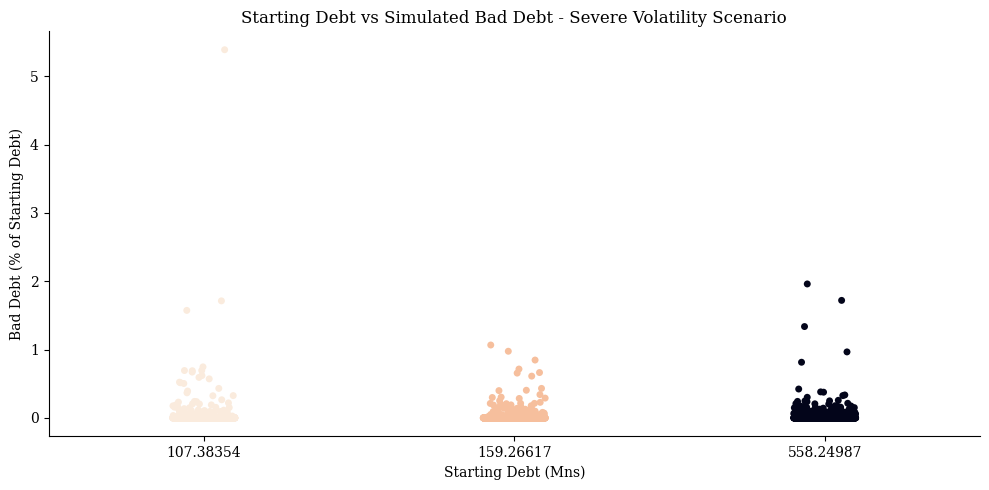

In [51]:
df = compare(results)

### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    # DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf.sort_values(["Starting Debt (Mns)"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Starting Debt (Mns)"]

# Swarm
bad_debts = []
for r, starting_debt in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append(
            {
                "Starting Debt (Mns)": starting_debt,
                "Bad Debt Pct": row["Bad Debt Pct On Controller Wbtc Max"],
            }
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Starting Debt (Mns)",
    y="Bad Debt Pct",
    hue="Starting Debt (Mns)",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Starting Debt (Mns)")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Starting Debt vs Simulated Bad Debt - Severe Volatility Scenario")
plt.tight_layout()
# plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

In [52]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.00000,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375
2,Severe vol and adverse growth,No Parameter,No Parameter,159.26617,70.90872,2.24607,neutral,severe,neutral,adverse,neutral,0.05332,0.00000,0.61871,2.50344,1.36081,13.80804,0.07173,0.04954,0.30738,0.09373,0.06600,0.39390,0.28810,0.17917,1.51941,0.15365,0.14808,0.19225
6,Severe vol and severe growth,No Parameter,No Parameter,558.24987,247.28053,2.25756,neutral,severe,neutral,severe,neutral,0.05920,0.01164,0.81577,2.69823,2.24708,8.69898,0.07631,0.06247,0.24725,0.09622,0.07938,0.29344,0.30873,0.26126,0.93215,0.12699,0.12484,0.18297


In [55]:
latex_table = (
    ndf[[DEBT, "Starting Debt (Mns)", "Bad Debt Pct Mean", "Bad Debt Pct p99"]]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrrr}
\toprule
debt & Starting Debt (Mns) & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
neutral & 107.38 & 0.04 & 0.88 \\
adverse & 159.27 & 0.05 & 0.62 \\
severe & 558.25 & 0.06 & 0.82 \\
\bottomrule
\end{tabular}



In [5]:
df

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
0,Very severe crvUSD Liquidity,No Parameter,No Parameter,107.09809,10.70902,10.00074,neutral,neutral,neutral,neutral,very severe,0.00005,0.00000,0.00000,0.00092,0.00000,0.02151,0.00552,0.00291,0.03571,0.01472,0.00622,0.14828,0.01477,0.00625,0.14828,0.12305,0.12025,0.17664
1,Severe crvUSD Liquidity,No Parameter,No Parameter,107.09218,22.18112,4.82808,neutral,neutral,neutral,neutral,severe,0.00000,0.00000,0.00000,0.00077,0.00000,0.00000,0.00573,0.00290,0.04051,0.01590,0.00616,0.16569,0.01595,0.00622,0.16569,0.12387,0.12205,0.18009
2,Severe vol and adverse growth,No Parameter,No Parameter,159.26617,70.90872,2.24607,neutral,severe,neutral,adverse,neutral,0.05332,0.00000,0.61871,2.50344,1.36081,13.80804,0.07173,0.04954,0.30738,0.09373,0.06600,0.39390,0.28810,0.17917,1.51941,0.15365,0.14808,0.19225
3,Adverse crvUSD Liquidity,No Parameter,No Parameter,107.22510,31.96305,3.35466,neutral,neutral,neutral,neutral,adverse,0.00002,0.00000,0.00000,0.00038,0.00000,0.00621,0.00556,0.00291,0.03643,0.01439,0.00582,0.14741,0.01442,0.00591,0.14741,0.12254,0.11993,0.18344
4,Baseline,No Parameter,No Parameter,107.38833,47.73094,2.24987,neutral,neutral,neutral,neutral,neutral,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00596,0.00298,0.04153,0.01565,0.00579,0.15176,0.01565,0.00579,0.15176,0.12405,0.12242,0.18206
5,Severe vol and severe crvUSD liquidity,No Parameter,No Parameter,108.30157,21.99535,4.92384,neutral,severe,neutral,neutral,severe,0.14948,0.00000,2.88584,2.20355,0.94692,15.62809,0.06175,0.03623,0.33037,0.08335,0.04559,0.42274,0.25041,0.13460,1.62002,0.12585,0.12257,0.18716
6,Severe vol and severe growth,No Parameter,No Parameter,558.24987,247.28053,2.25756,neutral,severe,neutral,severe,neutral,0.05920,0.01164,0.81577,2.69823,2.24708,8.69898,0.07631,0.06247,0.24725,0.09622,0.07938,0.29344,0.30873,0.26126,0.93215,0.12699,0.12484,0.18297
7,Severe vol and very severe crvUSD liquidity,No Parameter,No Parameter,108.45865,10.60554,10.22660,neutral,severe,neutral,neutral,very severe,0.29797,0.00000,8.59297,2.07354,0.92161,14.19082,0.05760,0.03451,0.31654,0.07875,0.04428,0.45066,0.23366,0.12103,1.64195,0.15029,0.12127,0.45821
8,Severe Growth,No Parameter,No Parameter,553.25216,247.67297,2.23380,neutral,neutral,neutral,severe,neutral,0.00002,0.00000,0.00000,0.00319,0.00000,0.06076,0.00684,0.00585,0.02040,0.01647,0.01278,0.06195,0.01670,0.01287,0.06505,0.12344,0.12243,0.17582
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.00000,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375


# Liquidations Depeg

[WARNING][10:33:46][matplotlib.legend]-43090: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


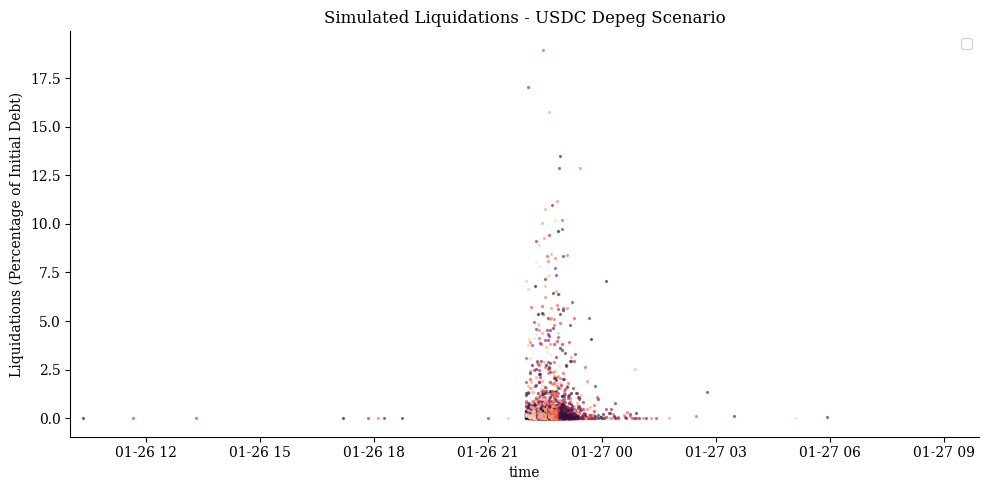

In [47]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

r = results[11]
cmap = plt.colormaps.get_cmap('rocket_r')

for i, datum in enumerate(r.data):
    ndf = datum.df["Debt Liquidated Pct"].diff().replace(0, pd.NA).dropna()
    ax.scatter(ndf.index, ndf, color=cmap(i % cmap.N), s=2, alpha=0.5)

ax.legend()
ax.set_title("Simulated Liquidations - USDC Depeg Scenario")
ax.set_ylabel("Liquidations (Percentage of Initial Debt)")
ax.set_xlabel("time")
ax.set_xlim(r.data[0].df.index[0], r.data[0].df.index[-1])
f.tight_layout()
f.savefig("../figs/results/depeg_liquidations.png", dpi=300)
plt.show()

# PK Debts

In [75]:
df

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pk Debt Mean,Pk Debt Median,Pk Debt p99
0,Very severe crvUSD Liquidity,No Parameter,No Parameter,107.09809,10.70902,10.00074,neutral,neutral,neutral,neutral,very severe,0.00005,0.00000,0.00000,0.00092,0.00000,0.02151,0.00552,0.00291,0.03571,0.01472,0.00622,0.14828,0.01477,0.00625,0.14828,0.12305,0.12025,0.17664,1.307167e+07,1.232674e+07,2.194294e+07
1,Severe crvUSD Liquidity,No Parameter,No Parameter,107.09218,22.18112,4.82808,neutral,neutral,neutral,neutral,severe,0.00000,0.00000,0.00000,0.00077,0.00000,0.00000,0.00573,0.00290,0.04051,0.01590,0.00616,0.16569,0.01595,0.00622,0.16569,0.12387,0.12205,0.18009,1.275672e+07,1.232674e+07,2.127563e+07
2,Severe vol and adverse growth,No Parameter,No Parameter,159.26617,70.90872,2.24607,neutral,severe,neutral,adverse,neutral,0.05332,0.00000,0.61871,2.50344,1.36081,13.80804,0.07173,0.04954,0.30738,0.09373,0.06600,0.39390,0.28810,0.17917,1.51941,0.15365,0.14808,0.19225,1.502190e+07,1.232674e+07,4.629012e+07
3,Adverse crvUSD Liquidity,No Parameter,No Parameter,107.22510,31.96305,3.35466,neutral,neutral,neutral,neutral,adverse,0.00002,0.00000,0.00000,0.00038,0.00000,0.00621,0.00556,0.00291,0.03643,0.01439,0.00582,0.14741,0.01442,0.00591,0.14741,0.12254,0.11993,0.18344,1.265520e+07,1.232674e+07,2.027531e+07
4,Baseline,No Parameter,No Parameter,107.38833,47.73094,2.24987,neutral,neutral,neutral,neutral,neutral,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00596,0.00298,0.04153,0.01565,0.00579,0.15176,0.01565,0.00579,0.15176,0.12405,0.12242,0.18206,1.257510e+07,1.232674e+07,1.983711e+07
5,Severe vol and severe crvUSD liquidity,No Parameter,No Parameter,108.30157,21.99535,4.92384,neutral,severe,neutral,neutral,severe,0.14948,0.00000,2.88584,2.20355,0.94692,15.62809,0.06175,0.03623,0.33037,0.08335,0.04559,0.42274,0.25041,0.13460,1.62002,0.12585,0.12257,0.18716,1.574387e+07,1.232674e+07,4.332890e+07
6,Severe vol and severe growth,No Parameter,No Parameter,558.24987,247.28053,2.25756,neutral,severe,neutral,severe,neutral,0.05920,0.01164,0.81577,2.69823,2.24708,8.69898,0.07631,0.06247,0.24725,0.09622,0.07938,0.29344,0.30873,0.26126,0.93215,0.12699,0.12484,0.18297,1.742541e+07,1.232674e+07,6.232674e+07
7,Severe vol and very severe crvUSD liquidity,No Parameter,No Parameter,108.45865,10.60554,10.22660,neutral,severe,neutral,neutral,very severe,0.29797,0.00000,8.59297,2.07354,0.92161,14.19082,0.05760,0.03451,0.31654,0.07875,0.04428,0.45066,0.23366,0.12103,1.64195,0.15029,0.12127,0.45821,1.701283e+07,1.383915e+07,4.297648e+07
8,Severe Growth,No Parameter,No Parameter,553.25216,247.67297,2.23380,neutral,neutral,neutral,severe,neutral,0.00002,0.00000,0.00000,0.00319,0.00000,0.06076,0.00684,0.00585,0.02040,0.01647,0.01278,0.06195,0.01670,0.01287,0.06505,0.12344,0.12243,0.17582,1.291505e+07,1.232674e+07,3.429106e+07
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.00000,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375,1.425154e+07,1.232674e+07,3.948816e+07


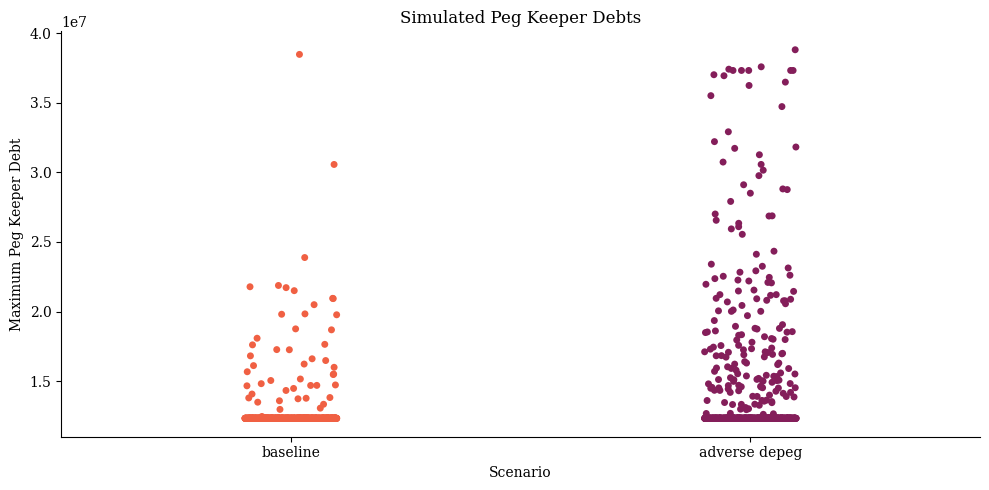

In [83]:
# 4 = baseline, 11 = depeg

# Baseline
nresults = [results[i] for i in [4, 11]]
pk_debts = []
for r in nresults:
    for i, row in r.summary.iterrows():
        pk_debts.append(
            {
                "Scenario": r.metadata["scenario"],
                "PK Debt Max": row["Pk Debt Max"],
            }
        )

pk_debts = pd.DataFrame(pk_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=pk_debts,
    x="Scenario",
    y="PK Debt Max",
    hue="Scenario",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Scenario")
# plt.xticks(range(len(labels)), labels)
plt.ylabel("Maximum Peg Keeper Debt")
plt.title("Simulated Peg Keeper Debts")
plt.tight_layout()
# plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

In [99]:
print((df.iloc[[4,11]][["Name", "Pk Debt Mean", "Pk Debt Median", "Pk Debt p99"]].set_index("Name") / 1e6).to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Pk Debt Mean & Pk Debt Median & Pk Debt p99 \\
Name &  &  &  \\
\midrule
Baseline & 12.58 & 12.33 & 19.84 \\
Adverse depeg & 13.74 & 12.33 & 36.49 \\
\bottomrule
\end{tabular}



In [100]:
ndf = results[11].summary
ndf[ndf["Pk Crvusd/Usdc Debt Max"] > 24e6]#.shape[0]

,Bad Debt Pct Max,Bad Debt Pct On Controller Wbtc Max,Bad Debt Pct On Controller Weth Max,Bad Debt Pct On Controller Sfrxeth Max,Bad Debt Pct On Controller Wsteth Max,System Health Min,System Health On Controller Wbtc Min,System Health On Controller Weth Min,System Health On Controller Sfrxeth Min,System Health On Controller Wsteth Min,Borrower Loss Pct Max,Hard Liquidation Loss Pct Max,Soft Liquidation Loss Pct Max,Value Leakage Max,Keeper Profit Max,Keeper Count Max,Keeper Profit On Pk Crvusd/Tusd Max,Keeper Count On Pk Crvusd/Tusd Max,Keeper Profit On Pk Crvusd/Usdp Max,Keeper Count On Pk Crvusd/Usdp Max,Keeper Profit On Pk Crvusd/Usdc Max,Keeper Count On Pk Crvusd/Usdc Max,Keeper Profit On Pk Crvusd/Usdt Max,Keeper Count On Pk Crvusd/Usdt Max,Liquidator Profit Max,Liquidator Count Max,Liquidator Profit On Controller Wbtc Max,Liquidator Count On Controller Wbtc Max,Liquidator Profit On Controller Weth Max,Liquidator Count On Controller Weth Max,Liquidator Profit On Controller Sfrxeth Max,Liquidator Count On Controller Sfrxeth Max,Liquidator Profit On Controller Wsteth Max,Liquidator Count On Controller Wsteth Max,Arbitrageur Profit Max,Arbitrageur Count Max,Aggregator Price Max,Aggregator Price Min,Stableswap Crvusd_Tusd Price Max,Stableswap Crvusd_Tusd Price Min,Stableswap Crvusd_Usdp Price Max,Stableswap Crvusd_Usdp Price Min,Stableswap Crvusd_Usdc Price Max,Stableswap Crvusd_Usdc Price Min,Stableswap Crvusd_Usdt Price Max,Stableswap Crvusd_Usdt Price Min,Debt Liquidated Pct Max,Debt Liquidated Pct On Controller Wbtc Max,Debt Liquidated Pct On Controller Weth Max,Debt Liquidated Pct On Controller Sfrxeth Max,Debt Liquidated Pct On Controller Wsteth Max,Pk Debt Max,Pk Crvusd/Tusd Debt Max,Pk Crvusd/Usdp Debt Max,Pk Crvusd/Usdc Debt Max,Pk Crvusd/Usdt Debt Max,Total Crvusd Liquidity Min,Stableswap Crvusd_Tusd Crvusd Liquidity Min,Stableswap Crvusd_Usdp Crvusd Liquidity Min,Stableswap Crvusd_Usdc Crvusd Liquidity Min,Stableswap Crvusd_Usdt Crvusd Liquidity Min,Total Debt Mean,Controller Wbtc Total Debt Mean,Controller Weth Total Debt Mean,Controller Sfrxeth Total Debt Mean,Controller Wsteth Total Debt Mean,Worst Oracle Error Pct Max,Llamma Wbtc Price Mean,Llamma Wbtc Oracle Price Mean,Llamma Wbtc Oracle Error Pct Max,Llamma Weth Price Mean,Llamma Weth Oracle Price Mean,Llamma Weth Oracle Error Pct Max,Llamma Sfrxeth Price Mean,Llamma Sfrxeth Oracle Price Mean,Llamma Sfrxeth Oracle Error Pct Max,Llamma Wsteth Price Mean,Llamma Wsteth Oracle Price Mean,Llamma Wsteth Oracle Error Pct Max,Net Llamma Profit Pct Max,Llamma Profit On Llamma Wbtc Pct Max,Llamma Profit On Llamma Weth Pct Max,Llamma Profit On Llamma Sfrxeth Pct Max,Llamma Profit On Llamma Wsteth Pct Max
Run ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.137511,0.325491,0.084257,0.0,0.000000,0.870813,1.255759,0.669384,1.055772,0.485449,2.818712,2.778744,0.039992,6.004898e+06,16903.943788,36.0,0.0,0.0,0.000000,0.0,16903.943788,36.0,0.0,0.0,3.409707e+06,20.0,268761.269824,9.0,39773.694190,6.0,0.000000,0.0,3.101172e+06,5.0,2.578287e+06,395.0,1.004362,0.872133,1.012554,0.802807,1.000385,0.804684,1.033683,0.998447,0.999875,0.802789,8.673539,1.807235,1.029808,0.000000,20.871855,3.702014e+07,4.939855e+06,0.000000e+00,2.469340e+07,7.386882e+06,3.936202e+07,8.772067e+05,1.768053e+06,3.371331e+06,1.398281e+07,9.841742e+07,3.927183e+07,1.460444e+07,9.923433e+06,3.461772e+07,16.819888,40828.072146,40536.223623,16.819888,2249.900551,2233.167644,16.819888,1796.993664,2388.491069,16.819888,2682.317785,2569.531638,16.819888,0.027400,0.010196,0.008182,0.000000,0.059447
95,0.190224,0.098359,1.589132,0.0,0.000000,1.015599,1.106676,0.540513,0.889527,1.069223,0.597338,0.227430,0.369908,4.712385e+06,21267.749047,36.0,0.0,0.0,40.489256,8.0,21227.259791,28.0,0.0,0.0,4.074642e+05,27.0,161630.181004,8.0,154717.841545,10.0,6944.965537,1.0,8.417121e+04,8.0,4.283653e+06,484.0,1.003601,0.920688,1.016188,0.845909,1.001861,0.843283,1.108728,0.999649,1.00020

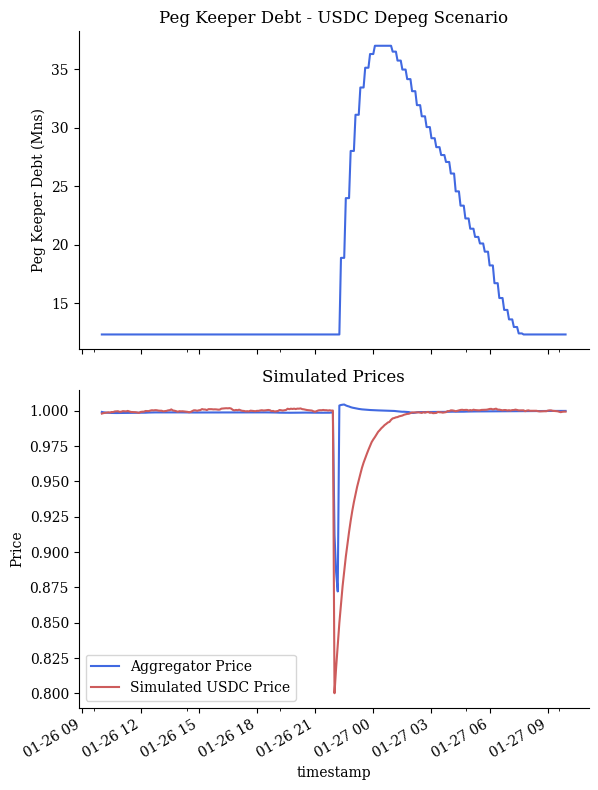

In [129]:
from src.configs.tokens import *
f, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

ax = axs[0]
(results[11].data[0].df["PK Debt"] / 1e6).plot(ax=ax, color="royalblue")
ax.set_ylabel("Peg Keeper Debt (Mns)")
ax.set_title("Peg Keeper Debt - USDC Depeg Scenario")

ax = axs[1]
results[11].data[0].df["Aggregator Price"].plot(ax=ax, color="royalblue", label="Aggregator Price")
results[11].data[0].pricepaths.prices[USDC].plot(ax=ax, color="indianred", label="Simulated USDC Price")
ax.legend()
ax.set_ylabel("Price")
ax.set_title("Simulated Prices")

f.tight_layout()
f.savefig("../figs/results/depeg_pk_debt.png", dpi=300)
plt.show()

<Axes: xlabel='timestamp'>

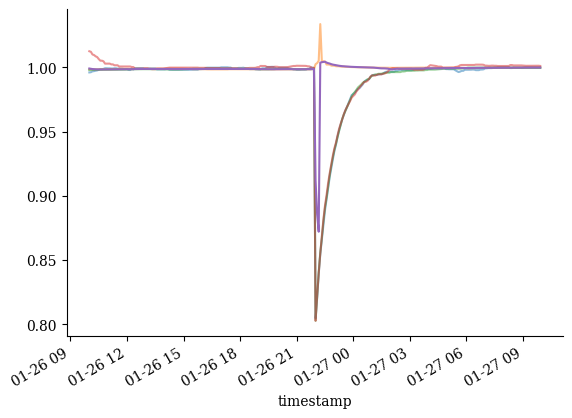

In [123]:
results[11].data[0].df["Stableswap Crvusd_Usdp Price"].plot(alpha=0.5)
results[11].data[0].df["Stableswap Crvusd_Usdc Price"].plot(alpha=0.5)
results[11].data[0].df["Stableswap Crvusd_Usdt Price"].plot(alpha=0.5)
results[11].data[0].df["Stableswap Crvusd_Tusd Price"].plot(alpha=0.5)
results[11].data[0].df["Aggregator Price"].plot()

# Bad Debt vs Volatility

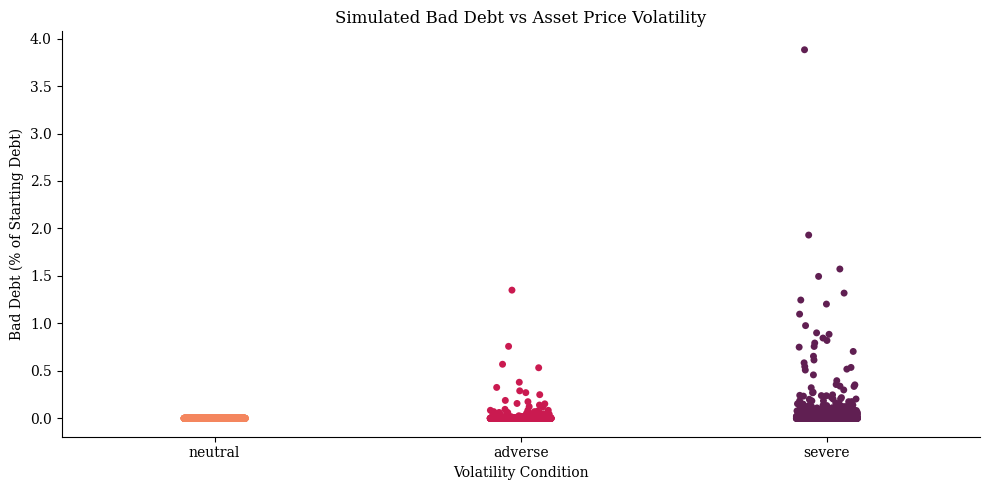

In [119]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

order_tags(ndf, VOL)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf[VOL]

bad_debts = []
for r, vol in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append({"Volatility": vol, "Bad Debt Pct": row["Bad Debt Pct Max"]})
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Volatility",
    y="Bad Debt Pct",
    hue="Volatility",
    legend=False,
    palette="rocket_r",
)
# plt.yscale("log")
plt.xlabel("Volatility Condition")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Simulated Bad Debt vs Asset Price Volatility")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_vol.png", dpi=300)
plt.show()

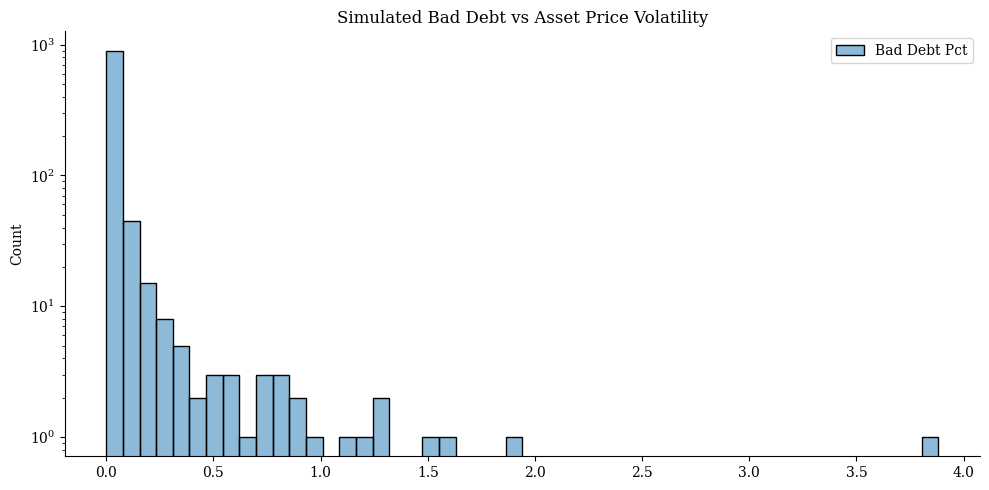

In [135]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

order_tags(ndf, VOL)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf[VOL]

bad_debts = []
for r, vol in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append({"Volatility": vol, "Bad Debt Pct": row["Bad Debt Pct Max"]})
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.histplot(
    data=bad_debts[bad_debts["Volatility"] == SEVERE],
    bins=50,
)
plt.yscale("log")
# plt.xlabel("Volatility Condition")
# plt.xticks(range(len(labels)), labels)
# plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Simulated Bad Debt vs Asset Price Volatility")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_vol.png", dpi=300)
plt.show()

In [114]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
4,Baseline,No Parameter,No Parameter,107.38833,47.73094,2.24987,neutral,neutral,neutral,neutral,neutral,0.00000,0.0,0.00000,0.00004,0.00000,0.00000,0.00596,0.00298,0.04153,0.01565,0.00579,0.15176,0.01565,0.00579,0.15176,0.12405,0.12242,0.18206
12,Adverse vol,No Parameter,No Parameter,107.22853,47.75787,2.24525,neutral,adverse,neutral,neutral,neutral,0.00813,0.0,0.17518,0.80491,0.23809,9.63255,0.04376,0.02410,0.24298,0.04670,0.02507,0.27766,0.11036,0.05147,1.05094,0.12220,0.12007,0.17600
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.0,0.88483,2.50121,1.14014,16.54635,0.06997,0.04526,0.33021,0.09155,0.05676,0.41212,0.29135,0.16042,1.95163,0.12352,0.12066,0.17375


In [ ]:
latex_table = (
    ndf[[VOL, "Bad Debt Pct Median", "Bad Debt Pct Mean", "Bad Debt Pct p99"]]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrrr}
\toprule
vol & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
neutral & 0.00 & 0.00 & 0.00 \\
adverse & 0.00 & 0.01 & 0.18 \\
severe & 0.00 & 0.04 & 0.88 \\
\bottomrule
\end{tabular}



# Bad Debt vs crvUSD Liquidity

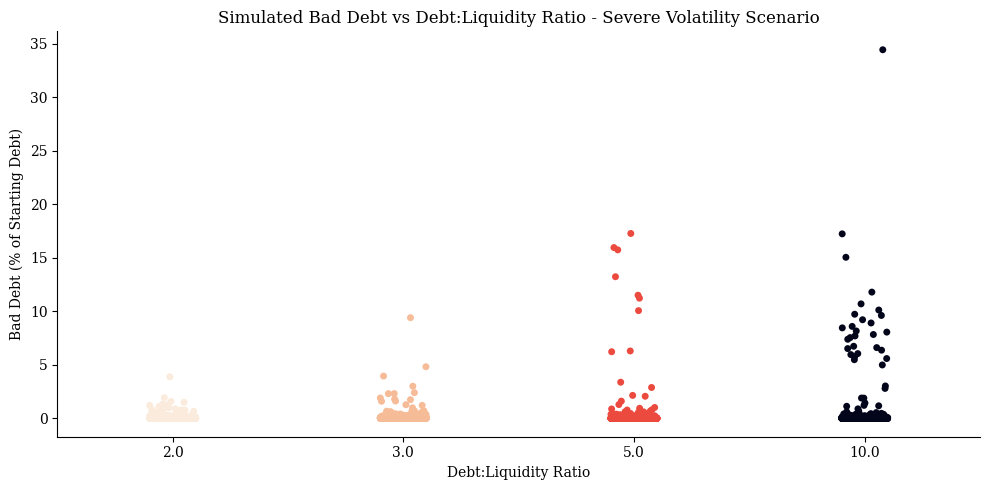

In [ ]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    # LIQUIDITY: ADVERSE,
    DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

ndf.sort_values(["Starting Debt:Liquidity Ratio"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = round(ndf["Starting Debt:Liquidity Ratio"])

bad_debts = []
for r, ratio in zip(nresults, labels):
    for _, row in r.summary.iterrows():
        bad_debts.append(
            {
                "Starting Debt:Liquidity Ratio": ratio,
                "Bad Debt Pct": row["Bad Debt Pct Max"],
            }
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Starting Debt:Liquidity Ratio",
    y="Bad Debt Pct",
    hue="Starting Debt:Liquidity Ratio",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Debt:Liquidity Ratio")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Simulated Bad Debt vs Debt:Liquidity Ratio - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_ratio.png", dpi=300)
plt.show()

In [ ]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Bad Debt Pct > 1\%,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Debt Liquidated Pct > 1\%,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Net Llamma Profit Pct > 1\%,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Soft Liquidation Loss Pct > 1\%,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Borrower Loss Pct > 1\%,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Worst Oracle Error Pct > 1\%
9,Severe vol,No Parameter,No Parameter,107.38354,47.69700,2.25137,neutral,severe,neutral,neutral,neutral,0.04310,0.0,0.88483,0.8,2.50121,1.14014,16.54635,54.0,0.06997,0.04526,0.33021,0.0,0.09155,0.05676,0.41212,0.0,0.29135,0.16042,1.95163,5.5,0.12352,0.12066,0.17375,0.0
13,Severe vol and adverse crvUSD liquidity,No Parameter,No Parameter,108.12554,31.84887,3.39496,neutral,severe,neutral,neutral,adverse,0.06404,0.0,1.61561,1.4,2.19796,1.01120,15.15261,50.1,0.06433,0.04038,0.31092,0.0,0.08655,0.04975,0.38472,0.1,0.25783,0.13508,1.47409,4.3,0.13486,0.12111,0.18048,0.1
5,Severe vol and severe crvUSD liquidity,No Parameter,No Parameter,108.30157,21.99535,4.92384,neutral,severe,neutral,neutral,severe,0.14948,0.0,2.88584,1.6,2.20355,0.94692,15.62809,48.2,0.06175,0.03623,0.33037,0.0,0.08335,0.04559,0.42274,0.1,0.25041,0.13460,1.62002,4.5,0.12585,0.12257,0.18716,0.0
7,Severe vol and very severe crvUSD liquidity,No Parameter,No Parameter,108.45865,10.60554,10.22660,neutral,severe,neutral,neutral,very severe,0.29797,0.0,8.59297,3.6,2.07354,0.92161,14.19082,48.1,0.05760,0.03451,0.31654,0.0,0.07875,0.04428,0.45066,0.3,0.23366,0.12103,1.64195,3.5,0.15029,0.12127,0.45821,0.5


In [ ]:
latex_table = (
    ndf[
        [
            "Starting Debt:Liquidity Ratio",
            "Bad Debt Pct Median",
            "Bad Debt Pct Mean",
            "Bad Debt Pct p99",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
Starting Debt:Liquidity Ratio & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
2.25 & 0.00 & 0.04 & 0.88 \\
3.39 & 0.00 & 0.06 & 1.62 \\
4.92 & 0.00 & 0.15 & 2.89 \\
10.23 & 0.00 & 0.30 & 8.59 \\
\bottomrule
\end{tabular}



# Flash Crashes

In [ ]:
results = get_results("../results/generic/")
df = compare(results)
print(df.shape)
df

In [136]:
### Zoom in
ndf = df.copy()
ndf = ndf[ndf[JUMP] != NEUTRAL]
ndf = ndf[ndf[DEBT] == NEUTRAL]
ndf = ndf[ndf[LIQUIDITY] == NEUTRAL]
ndf = ndf[ndf["Name"] != "Adverse depeg"]

order_tags(ndf, JUMP)

ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99


In [ ]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    # MU: NEUTRAL,
    JUMP: SEVERE,
    # LIQUIDITY: NEUTRAL,
    # DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]

order_tags(ndf, VOL)

ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
14,Severe flash crash,No Parameter,No Parameter,107.00019,47.70969,2.24274,neutral,neutral,severe,neutral,neutral,5.00596,2.95151,21.84575,1.75648,0.86401,10.58558,0.04303,0.03482,0.13493,0.76639,0.49136,3.46719,0.85456,0.59458,3.61079,0.12577,0.11885,0.21222


In [99]:
foos = get_results("../results_250_iters/generic/")

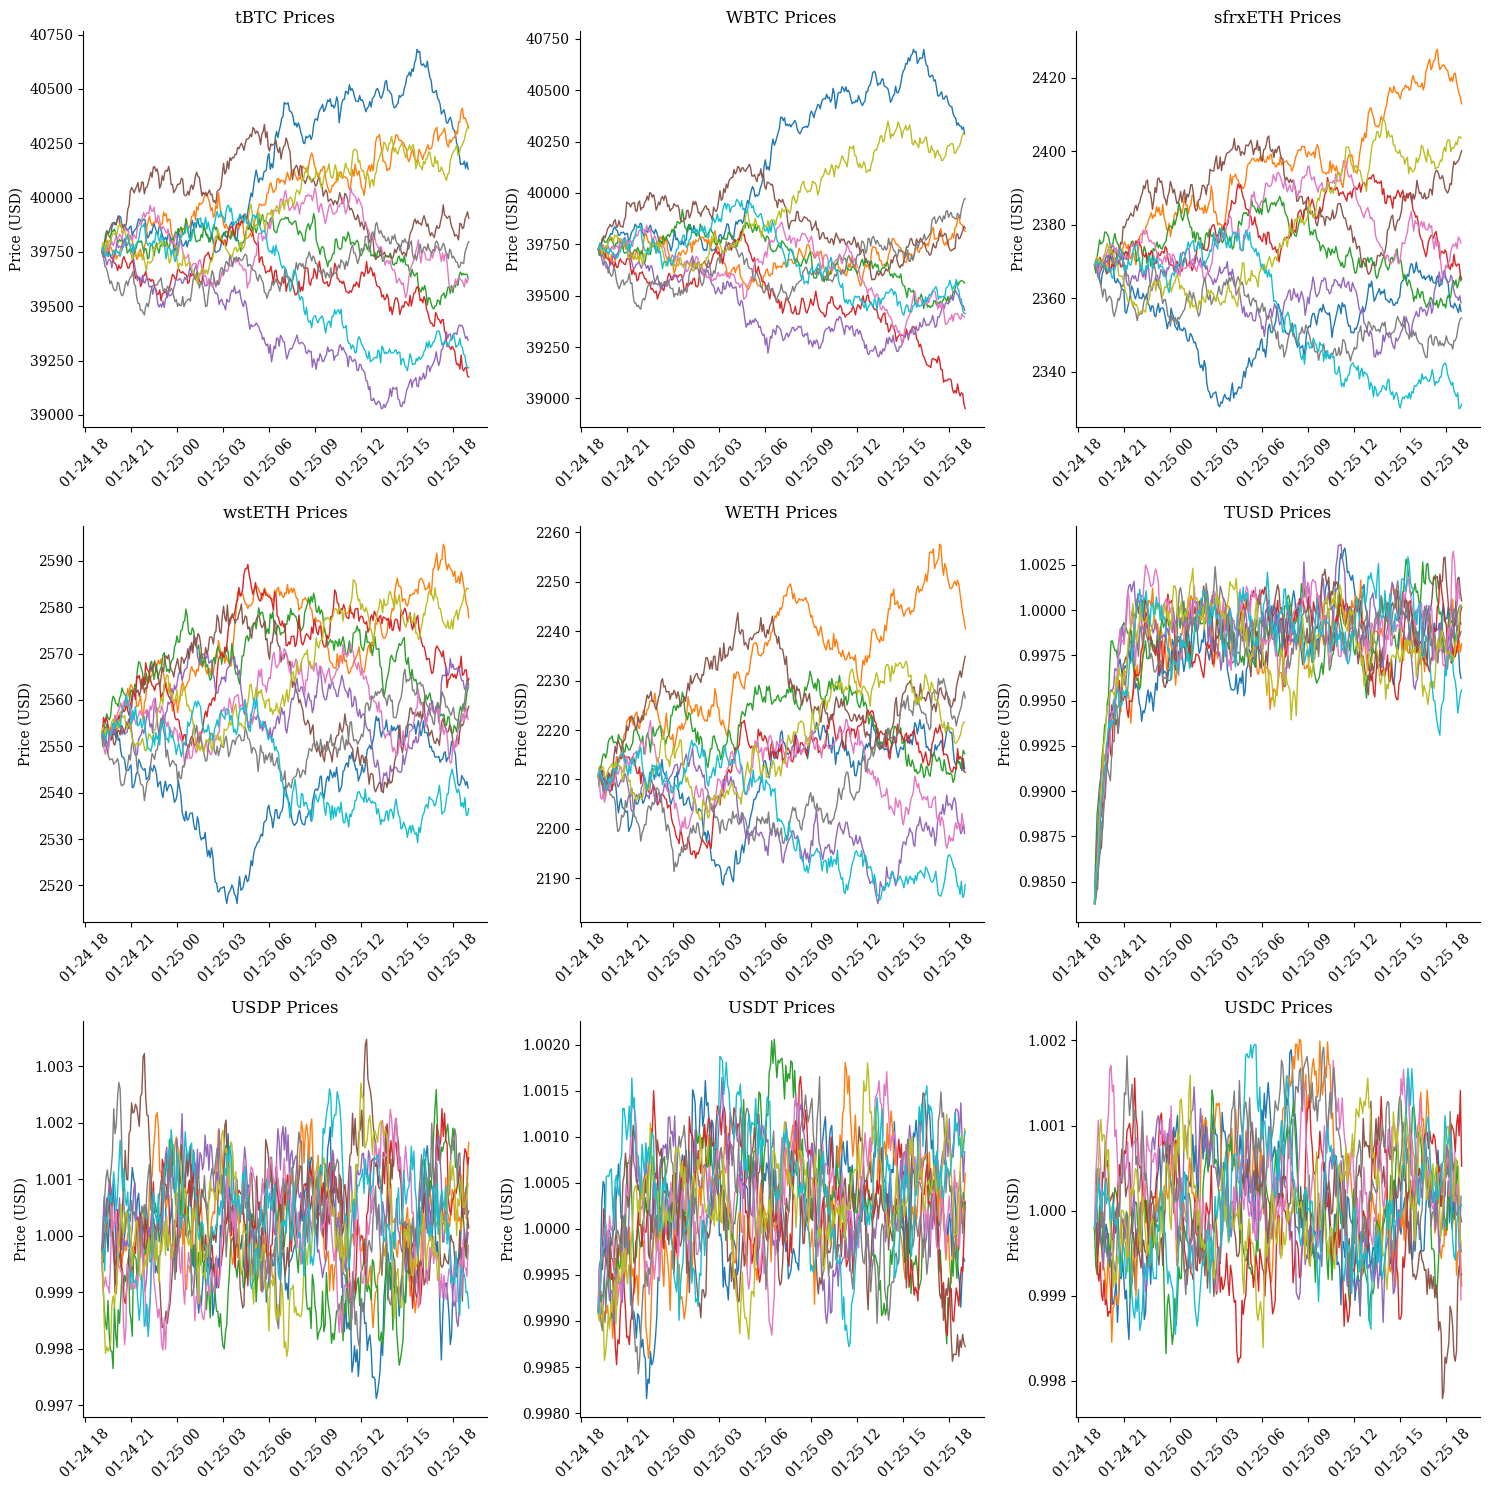

In [101]:
from src.plotting import plot_prices

foo = foos[0]
axs = plot_prices(foo.data[0].pricepaths.prices)
for datum in foo.data[1:10]:
    plot_prices(datum.pricepaths.prices, axs=axs)
plt.tight_layout()
# plt.savefig("../figs/results/pricepaths.png", dpi=300)
plt.show()

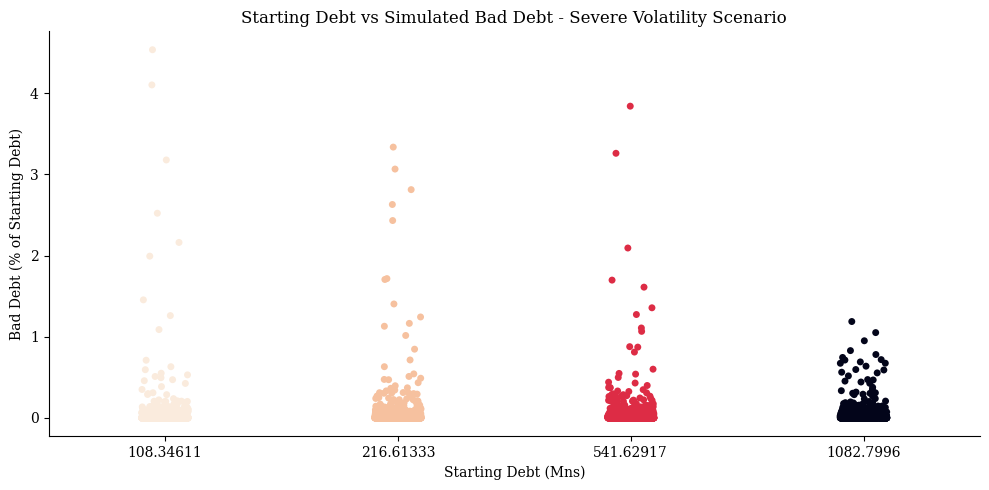

In [28]:
### Zoom in
ndf = df.copy()
shock_fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    # DEBT: NEUTRAL,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf.sort_values(["Starting Debt (Mns)"], inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Starting Debt (Mns)"]

# Swarm
bad_debts = []
for r, starting_debt in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        bad_debts.append(
            {
                "Starting Debt (Mns)": starting_debt,
                "Bad Debt Pct": row["Bad Debt Pct Max"],
            }
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
sns.stripplot(
    data=bad_debts,
    x="Starting Debt (Mns)",
    y="Bad Debt Pct",
    hue="Starting Debt (Mns)",
    legend=False,
    palette="rocket_r",
)
plt.xlabel("Starting Debt (Mns)")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Bad Debt (% of Starting Debt)")
plt.title("Starting Debt vs Simulated Bad Debt - Severe Volatility Scenario")
plt.tight_layout()
plt.savefig("../figs/results/bad_debt_vs_starting_debt.png", dpi=300)
plt.show()

In [29]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Bad Debt Pct > 1\%,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Debt Liquidated Pct > 1\%,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Net Llamma Profit Pct > 1\%,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Soft Liquidation Loss Pct > 1\%,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Borrower Loss Pct > 1\%,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Worst Oracle Error Pct > 1\%
7,Severe vol,debt_ceiling,1.0,108.34611,47.49775,2.28108,neutral,severe,neutral,neutral,neutral,0.04401,0.00000,0.63156,0.9,2.14831,0.99397,14.02132,49.7,0.06132,0.03921,0.30425,0.0,0.07797,0.04834,0.37595,0.0,0.24789,0.13199,1.51962,4.0,0.12292,0.12137,0.17476,0.0
1,Severe vol,debt_ceiling,2.0,216.61333,95.02775,2.27947,neutral,severe,neutral,neutral,neutral,0.05089,0.00000,1.12944,1.2,2.12368,1.29562,10.41259,58.3,0.06172,0.04368,0.22955,0.0,0.07830,0.05743,0.28691,0.0,0.24592,0.16534,1.11487,1.6,0.12306,0.12097,0.17284,0.0
4,Severe vol,debt_ceiling,5.0,541.62917,237.64209,2.27918,neutral,severe,neutral,neutral,neutral,0.04961,0.00625,0.87195,0.9,2.24362,1.78201,8.39371,68.2,0.06502,0.05208,0.24418,0.0,0.08305,0.06810,0.29809,0.0,0.25794,0.21004,0.85818,0.2,0.12268,0.12078,0.17815,0.0
10,Severe vol,debt_ceiling,10.0,1082.79960,475.32069,2.27804,neutral,severe,neutral,neutral,neutral,0.04005,0.00918,0.67310,0.2,2.37151,2.02553,7.36386,75.8,0.06689,0.05551,0.21162,0.0,0.08473,0.07154,0.25175,0.0,0.27081,0.24067,0.76765,0.0,0.12319,0.12173,0.17724,0.0


In [56]:
latex_table = (
    ndf[
        [
            "Starting Debt (Mns)",
            "Bad Debt Pct Median",
            "Bad Debt Pct Mean",
            "Bad Debt Pct p99",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{rrrr}
\toprule
Starting Debt (Mns) & Bad Debt Pct Median & Bad Debt Pct Mean & Bad Debt Pct p99 \\
\midrule
107.38 & 0.00 & 0.04 & 0.88 \\
159.27 & 0.00 & 0.05 & 0.62 \\
558.25 & 0.01 & 0.06 & 0.82 \\
\bottomrule
\end{tabular}



# LVR and Fees

How does this change as we vary fees?

In [187]:
results = get_results("../results/fees/")

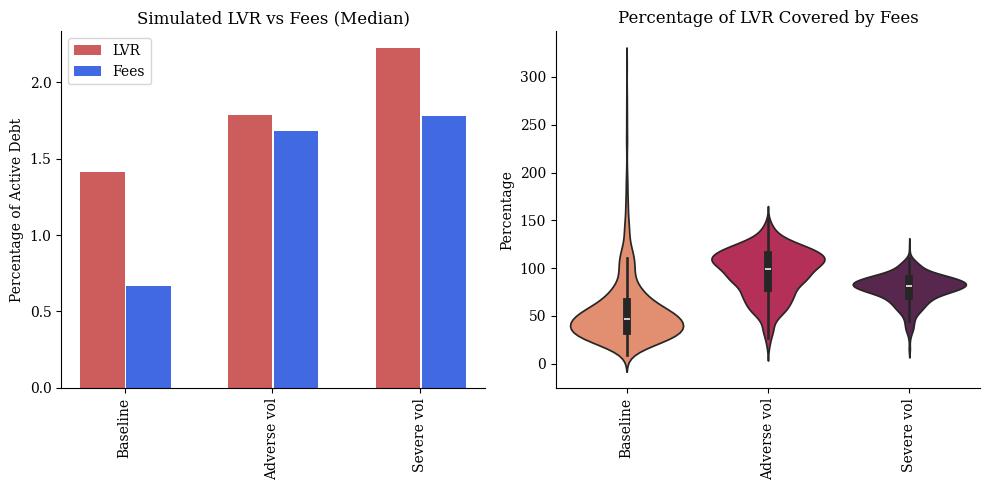

In [222]:
df = compare(results, include_lvr_metrics=True)

ndf = df.copy()
shock_fixes = {
    # VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
    "Value": 0.006,
}
for col, tag in shock_fixes.items():
    ndf = ndf[ndf[col] == tag]
order_tags(ndf, VOL)

labels = ndf["Name"]
width = 0.3
ind = np.arange(len(ndf))

f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.bar(
    ind,
    ndf["Soft Liquidation Loss Pct of Active Debt Median"],
    width=width,
    color="indianred",
    label="LVR",
)
ax.bar(
    ind + width + 0.01,
    ndf["Net Llamma Profit Pct of Active Debt Median"],
    width=width,
    color="royalblue",
    label="Fees",
)
ax.set_title("Simulated LVR vs Fees (Median)")
ax.set_ylabel("Percentage of Active Debt")
ax.tick_params(axis="x", rotation=90)
ax.set_xticks(ind + width / 2, labels)
ax.legend()

ax = axs[1]

idxs = ndf.index
nresults = [results[i] for i in idxs]
pcts = [nresult.summary["Pct of LVR Covered by Fees"].tolist() for nresult in nresults]

sns.violinplot(data=pcts, palette="rocket_r", inner="box")
ax.set_title("Percentage of LVR Covered by Fees")
ax.set_ylabel("Percentage")
ax.set_xticks(range(len(labels)), labels)
ax.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig("../figs/results/fees_lvr_pct.png", dpi=300)
plt.show()

In [223]:
latex_table = (
    ndf[[VOL, "Active Debt Pct Mean", "Active Debt Pct Median"]]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrr}
\toprule
vol & Active Debt Pct Mean & Active Debt Pct Median \\
\midrule
neutral & 0.66 & 0.33 \\
adverse & 2.16 & 1.25 \\
severe & 3.53 & 2.04 \\
\bottomrule
\end{tabular}



In [192]:
latex_table = (
    ndf[
        [
            VOL,
            "Soft Liquidation Loss Pct of Active Debt Median",
            "Soft Liquidation Loss Pct of Active Debt Mean",
            "Net Llamma Profit Pct of Active Debt Median",
            "Net Llamma Profit Pct of Active Debt Mean",
        ]
    ]
    .round(2)
    .to_latex(index=False, float_format="%.2f")
)
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
vol & Soft Liquidation Loss Pct of Active Debt Median & Soft Liquidation Loss Pct of Active Debt Mean & Net Llamma Profit Pct of Active Debt Median & Net Llamma Profit Pct of Active Debt Mean \\
\midrule
neutral & 1.41 & 1.80 & 0.67 & 0.66 \\
adverse & 1.78 & 1.90 & 1.68 & 1.76 \\
severe & 2.22 & 2.24 & 1.78 & 1.75 \\
\bottomrule
\end{tabular}



In [231]:
sum(results[0].data[0].active_debt.values())

221078.1206055884

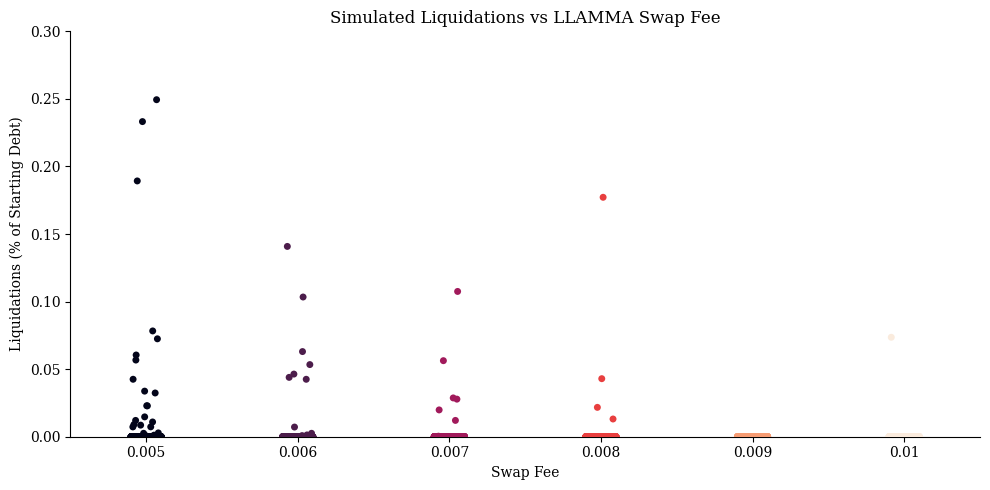

In [240]:
### Zoom in
ndf = filter_vol(df, NEUTRAL)
ndf.sort_values("Value", inplace=True)

idxs = ndf.index
nresults = [results[i] for i in idxs]
labels = ndf["Value"]

bad_debts = []
for r, label in zip(nresults, labels):
    for i, row in r.summary.iterrows():
        active_debt = sum(r.data[i].active_debt.values())
        initial_debt = sum(r.data[i].initial_debt.values())
        active_debt_pct = active_debt / initial_debt * 100
        bad_debts.append(
            {"Fee": label, "Debt Liquidated Pct": row["Debt Liquidated Pct Max"]}
            # {"Fee": label, "Debt Liquidated Pct of Active Debt": row["Debt Liquidated Pct Max"] / (active_debt_pct / 100)}
            
        )
bad_debts = pd.DataFrame(bad_debts)

plt.figure(figsize=(10, 5))
# sns.histplot(
#     data=bad_debts,
#     x="Debt Liquidated Pct",
#     palette="rocket_r",
#     multiple="stack",
#     hue="Fee",
# )
sns.stripplot(
    data=bad_debts,
    x="Fee",
    y="Debt Liquidated Pct",
    # y = "Debt Liquidated Pct of Active Debt",
    hue="Fee",
    legend=False,
    palette="rocket",
)
# plt.yscale("log")
plt.ylim(0, 0.3)
plt.xlabel("Swap Fee")
plt.xticks(range(len(labels)), labels)
plt.ylabel("Liquidations (% of Starting Debt)")
plt.title("Simulated Liquidations vs LLAMMA Swap Fee")
plt.tight_layout()
plt.savefig("../figs/results/debt_liquidated_vs_fee_baseline.png", dpi=300)
plt.show()

In [233]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median,Soft Liquidation Loss Pct of Active Debt Median,Net Llamma Profit Pct of Active Debt Median,Soft Liquidation Loss Pct of Active Debt Mean,Net Llamma Profit Pct of Active Debt Mean,Debt Liquidated Pct of Active Debt Mean
12,Baseline,fee,0.005,108.54362,47.54066,2.28317,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00117,0.0,0.02302,0.00400,0.00197,0.02985,0.01235,0.00467,0.13081,0.01243,0.00470,0.13081,0.12157,0.11998,0.17762,49.24719,39.91824,14.10643,0.69244,0.34024,1.37353,0.57771,1.78374,0.57775,0.16919
3,Baseline,fee,0.006,108.34285,47.57134,2.27748,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00119,0.0,0.00133,0.00438,0.00218,0.03506,0.01192,0.00460,0.12745,0.01201,0.00460,0.12745,0.12225,0.11999,0.17652,55.56621,46.38445,15.97155,0.66129,0.32613,1.41089,0.66912,1.80222,0.66282,0.17920
9,Baseline,fee,0.007,108.32919,47.58450,2.27656,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00526,0.00241,0.03955,0.01260,0.00405,0.12766,0.01262,0.00405,0.12766,0.12238,0.12084,0.17697,66.15110,53.59375,15.83771,0.69966,0.32400,1.24899,0.74352,1.80148,0.75117,0.03610
6,Baseline,fee,0.008,108.43053,47.55071,2.28031,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00537,0.00255,0.03509,0.01121,0.00402,0.12406,0.01123,0.00403,0.12406,0.12235,0.11999,0.18117,74.51466,59.02460,20.61063,0.65209,0.30480,1.31981,0.83680,1.71928,0.82425,0.03910
0,Baseline,fee,0.009,108.50913,47.61709,2.27879,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00603,0.00277,0.04636,0.01096,0.00376,0.12754,0.01096,0.00376,0.12754,0.12166,0.11874,0.17518,84.63932,67.34071,24.81553,0.66320,0.31745,1.18313,0.87407,1.65200,0.90961,0.00002
15,Baseline,fee,0.010,108.31790,47.53499,2.27870,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00007,0.0,0.00000,0.00616,0.00311,0.03989,0.00968,0.00355,0.10354,0.00968,0.00355,0.10354,0.12133,0.11972,0.17561,96.40651,76.47534,26.72283,0.63002,0.32059,1.10888,0.96871,1.53584,0.97793,0.01169


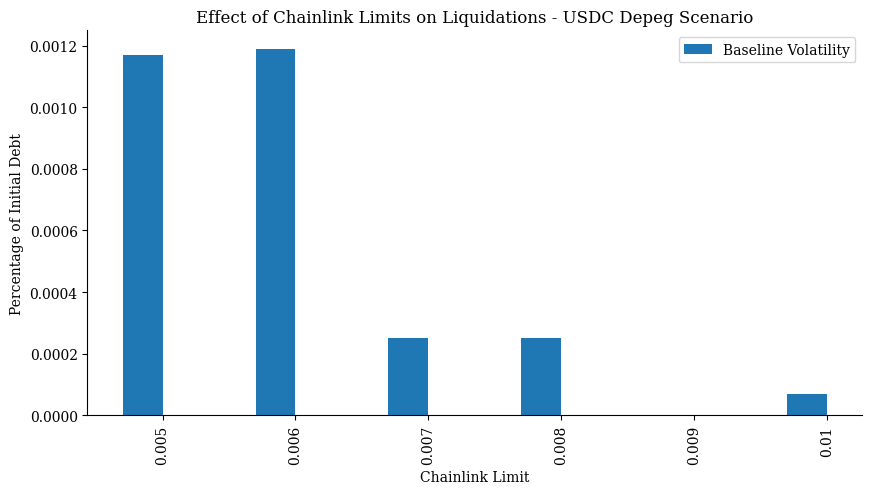

In [219]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

ndf = filter_vol(df, NEUTRAL)
ndf.sort_values("Value", inplace=True)

labels = ndf["Value"]
ind = np.arange(len(ndf))
width = 0.3

ax.bar(
    ind,
    ndf["Debt Liquidated Pct Mean"],
    width=width,
    # color="indianred",
    label="Baseline Volatility",
)

# ndf = filter_vol(df, ADVERSE)
# ndf.sort_values("Value", inplace=True)

# ax.bar(
#     ind + width + 0.01,
#     ndf["Debt Liquidated Pct Median"],
#     width=width,
#     # color="indianred",
#     label="Adverse Volatility",
# )

# ndf = filter_vol(df, SEVERE)
# ndf.sort_values("Value", inplace=True)

# ax.bar(
#     ind + 2*width + 0.01,
#     ndf["Debt Liquidated Pct Median"],
#     width=width,
#     # color="indianred",
#     label="Severe Volatility",
# )


ax.set_title("Effect of Chainlink Limits on Liquidations - USDC Depeg Scenario")
ax.set_ylabel("Percentage of Initial Debt")
ax.set_xlabel("Chainlink Limit")
ax.tick_params(axis="x", rotation=90)
ax.set_xticks(ind + width / 2, labels)
ax.legend()
plt.savefig("../figs/results/chainlink_limits.png", dpi=300)
plt.show()

In [220]:
ndf

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median,Soft Liquidation Loss Pct of Active Debt Median,Net Llamma Profit Pct of Active Debt Median,Soft Liquidation Loss Pct of Active Debt Mean,Net Llamma Profit Pct of Active Debt Mean
12,Baseline,fee,0.005,108.54362,47.54066,2.28317,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00117,0.0,0.02302,0.00400,0.00197,0.02985,0.01235,0.00467,0.13081,0.01243,0.00470,0.13081,0.12157,0.11998,0.17762,49.24719,39.91824,14.10643,0.69244,0.34024,1.37353,0.57771,1.78374,0.57775
3,Baseline,fee,0.006,108.34285,47.57134,2.27748,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00119,0.0,0.00133,0.00438,0.00218,0.03506,0.01192,0.00460,0.12745,0.01201,0.00460,0.12745,0.12225,0.11999,0.17652,55.56621,46.38445,15.97155,0.66129,0.32613,1.41089,0.66912,1.80222,0.66282
9,Baseline,fee,0.007,108.32919,47.58450,2.27656,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00526,0.00241,0.03955,0.01260,0.00405,0.12766,0.01262,0.00405,0.12766,0.12238,0.12084,0.17697,66.15110,53.59375,15.83771,0.69966,0.32400,1.24899,0.74352,1.80148,0.75117
6,Baseline,fee,0.008,108.43053,47.55071,2.28031,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00025,0.0,0.00000,0.00537,0.00255,0.03509,0.01121,0.00402,0.12406,0.01123,0.00403,0.12406,0.12235,0.11999,0.18117,74.51466,59.02460,20.61063,0.65209,0.30480,1.31981,0.83680,1.71928,0.82425
0,Baseline,fee,0.009,108.50913,47.61709,2.27879,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00603,0.00277,0.04636,0.01096,0.00376,0.12754,0.01096,0.00376,0.12754,0.12166,0.11874,0.17518,84.63932,67.34071,24.81553,0.66320,0.31745,1.18313,0.87407,1.65200,0.90961
15,Baseline,fee,0.010,108.31790,47.53499,2.27870,neutral,neutral,neutral,neutral,neutral,0.0,0.0,0.0,0.00007,0.0,0.00000,0.00616,0.00311,0.03989,0.00968,0.00355,0.10354,0.00968,0.00355,0.10354,0.12133,0.11972,0.17561,96.40651,76.47534,26.72283,0.63002,0.32059,1.10888,0.96871,1.53584,0.97793


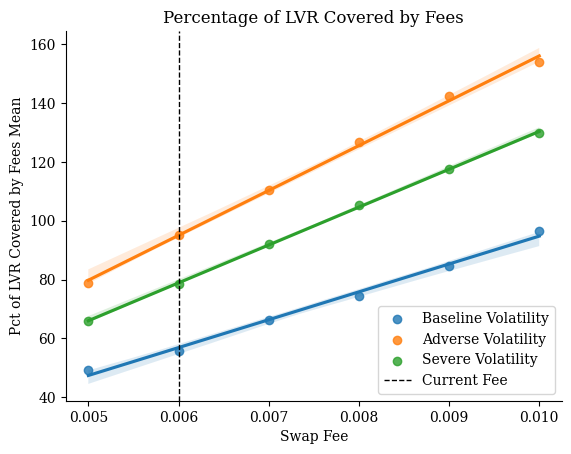

In [84]:
ndf = filter_vol(df, NEUTRAL)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Baseline Volatility",
)
ndf = filter_vol(df, ADVERSE)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Adverse Volatility",
)
ndf = filter_vol(df, SEVERE)
sns.regplot(
    data=ndf[["Value", "Pct of LVR Covered by Fees Mean"]],
    x="Value",
    y="Pct of LVR Covered by Fees Mean",
    order=1,
    label="Severe Volatility",
)
plt.axvline(0.006, linestyle="--", color="black", label="Current Fee", lw=1)
plt.title("Percentage of LVR Covered by Fees")
plt.xlabel("Swap Fee")
plt.legend()
plt.savefig("../figs/results/fees_lvr_pct_reg.png", dpi=300)
plt.show()

# Chainlink Limits

In [56]:
chainlink_results = get_results("../results/chainlink_limits")

In [57]:
df = compare(chainlink_results, include_lvr_metrics=True)
df.sort_values(["Value"], inplace=True)
df

,Name,Parameter,Value,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net Llamma Profit Pct Mean,Net Llamma Profit Pct Median,Net Llamma Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Borrower Loss Pct Mean,Borrower Loss Pct Median,Borrower Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pk Debt Mean,Pk Debt Median,Pk Debt p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01,Active Debt Pct Mean,Active Debt Pct Median,Soft Liquidation Loss Pct of Active Debt Median,Net Llamma Profit Pct of Active Debt Median,Soft Liquidation Loss Pct of Active Debt Mean,Net Llamma Profit Pct of Active Debt Mean,Debt Liquidated Pct of Active Debt Mean
0,Adverse depeg,chainlink_limit,0.015,108.40944,47.51989,2.28135,neutral,neutral,adverse,neutral,neutral,0.01302,0.00000,0.20842,0.03850,0.00000,1.27770,0.03123,0.02336,0.12195,0.01525,0.00493,0.14576,0.01717,0.00504,0.18709,1.49960,1.5000,1.5,1.311748e+07,1.186605e+07,3.037206e+07,1706.49932,363.12545,30.45336,2.35579,1.72066,0.28671,1.35749,0.64743,1.32548,1.63426
2,Adverse depeg,chainlink_limit,0.030,108.32281,47.54880,2.27814,neutral,neutral,adverse,neutral,neutral,0.13942,0.02239,1.72529,0.30647,0.00610,4.93918,0.02823,0.02140,0.11473,0.02268,0.00623,0.23475,0.04383,0.00730,0.57124,2.98867,3.0000,3.0,7.057482e+06,6.027362e+06,2.387360e+07,964.12088,312.19250,18.28219,1.99892,1.49058,0.41765,1.43572,1.13477,1.41210,15.33176
4,Adverse depeg,chainlink_limit,0.050,108.36533,47.59929,2.27662,neutral,neutral,adverse,neutral,neutral,0.12243,0.01403,1.36185,0.83919,0.20332,10.53495,0.02309,0.01673,0.10251,0.04052,0.00928,0.51377,0.10554,0.01490,1.23920,4.88019,5.0000,5.0,1.343358e+07,1.186605e+07,3.395932e+07,inf,182.64705,9.68047,1.88002,1.30616,0.71071,1.28082,2.15545,1.22842,44.63710
3,Adverse depeg,chainlink_limit,0.100,108.30081,47.57076,2.27663,neutral,neutral,adverse,neutral,neutral,0.07987,0.00000,1.26618,1.15734,0.40417,10.84271,0.01782,0.01257,0.08310,0.12355,0.05228,0.97586,0.20538,0.08112,2.17034,9.17631,10.0000,10.0,1.325807e+07,1.186605e+07,3.530034e+07,153.64257,15.65753,4.50937,1.71711,1.27294,4.10689,0.98760,7.19498,1.03755,67.40075
1,Adverse depeg,chainlink_limit,0.150,108.33511,47.52854,2.27937,neutral,neutral,adverse,neutral,neutral,0.24132,0.00000,5.93745,1.17006,0.40109,11.92478,0.01952,0.01263,0.09502,0.17319,0.06105,1.69398,0.25038,0.09375,2.44265,11.63460,12.6617,15.0,1.321210e+07,1.186605e+07,3.553274e+07,192.91131,14.47999,3.07063,1.83959,1.29944,4.69832,0.97208,9.41473,1.06110,63.60418


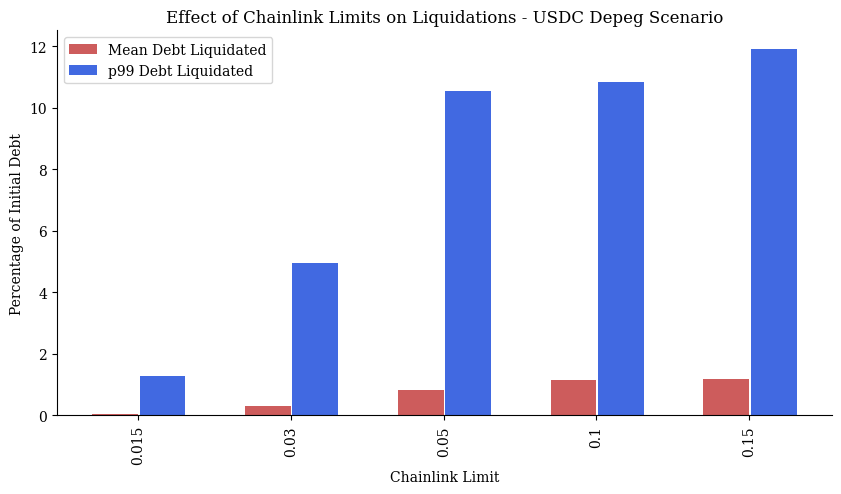

In [92]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

labels = df["Value"]
ind = np.arange(len(df))
width = 0.3

ax.bar(
    ind,
    df["Debt Liquidated Pct Mean"],
    width=width,
    color="indianred",
    label="Mean Debt Liquidated",
)
ax.bar(
    ind + width + 0.01,
    df["Debt Liquidated Pct p99"],
    width=width,
    color="royalblue",
    label="p99 Debt Liquidated",
)
ax.set_title("Effect of Chainlink Limits on Liquidations - USDC Depeg Scenario")
ax.set_ylabel("Percentage of Initial Debt")
ax.set_xlabel("Chainlink Limit")
ax.tick_params(axis="x", rotation=90)
ax.set_xticks(ind + width / 2, labels)
ax.legend()
plt.savefig("../figs/results/chainlink_limits.png", dpi=300)
plt.show()

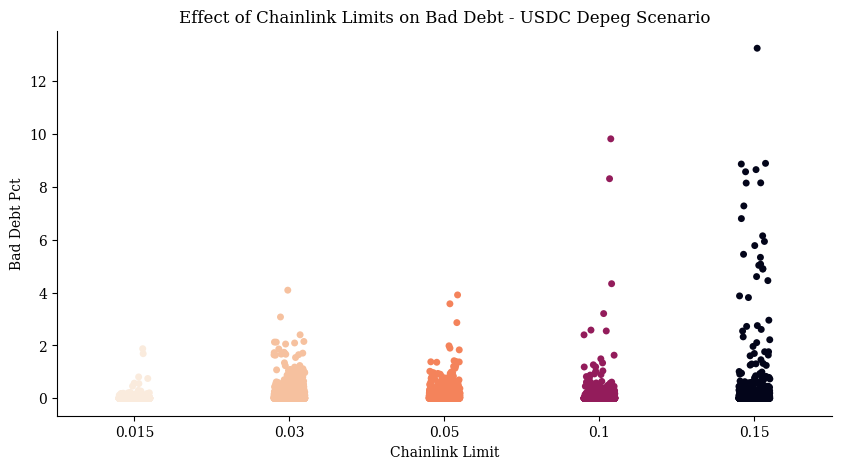

In [64]:
bad_debts = []
for r in chainlink_results:
    limit = r.metadata["params"]["chainlink_limit"] / 1e18
    for _, row in r.summary.iterrows():
        bad_debts.append(
            {"Chainlink Limit": limit, "Bad Debt Pct": row["Bad Debt Pct Max"]}
        )
bad_debts = pd.DataFrame(bad_debts)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.stripplot(
    data=bad_debts,
    x="Chainlink Limit",
    y="Bad Debt Pct",
    hue="Chainlink Limit",
    legend=False,
    palette="rocket_r",
    ax=ax,
)
plt.title("Effect of Chainlink Limits on Bad Debt - USDC Depeg Scenario")
plt.savefig("../figs/results/chainlink_limits_swarm.png", dpi=300)
plt.show()

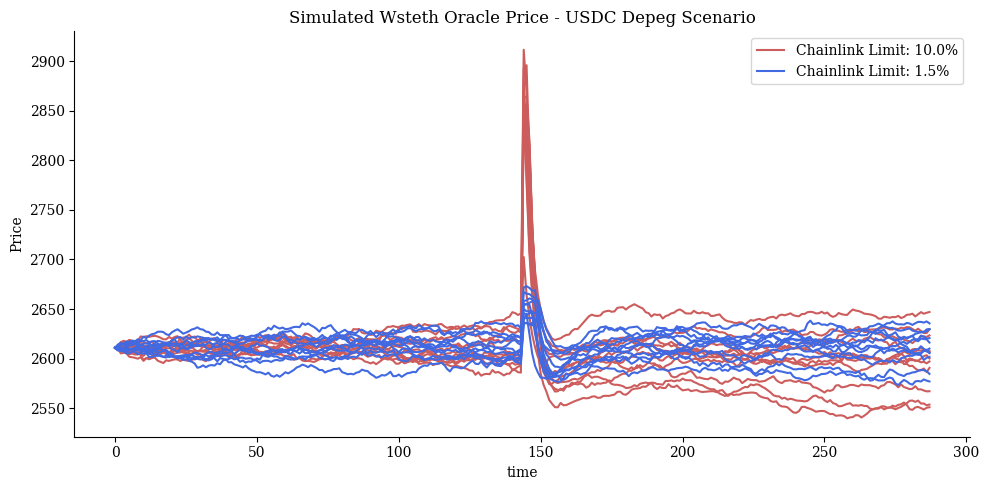

In [63]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

r = chainlink_results[3]
limit = r.metadata["params"]["chainlink_limit"] / 1e18 * 100
for datum in r.data[:10]:
    ax.plot(datum.df.reset_index()["Llamma Wsteth Oracle Price"], color="indianred")
ax.plot(
    r.data[25].df.reset_index()["Llamma Wsteth Oracle Price"],
    color="indianred",
    label=f"Chainlink Limit: {limit}%",
)

r = chainlink_results[0]
limit = r.metadata["params"]["chainlink_limit"] / 1e18 * 100
for datum in r.data[:10]:
    ax.plot(datum.df.reset_index()["Llamma Wsteth Oracle Price"], color="royalblue")
ax.plot(
    r.data[25].df.reset_index()["Llamma Wsteth Oracle Price"],
    color="royalblue",
    label=f"Chainlink Limit: {limit}%",
)

ax.legend()
ax.set_title("Simulated Wsteth Oracle Price - USDC Depeg Scenario")
ax.set_ylabel("Price")
ax.set_xlabel("time")
f.tight_layout()
f.savefig("../figs/results/chainlink_limits_oracle.png", dpi=300)
plt.show()

In [134]:
gauges = [
    ["USDT/crvUSD (0x390f…7BF4)", 3.2843930811204000, "7.86% to 19.64%"],
    ["USDC/crvUSD (0x4DEc…D69E)", 2.696517313415920, "5.49% to 13.71%"],
    ["USDP/crvUSD (0xCa97…53D0)", 0.5483185490771600, "9.05% to 22.62%"],
    ["TUSD/crvUSD (0x34D6…8db0)", 0.45740485280644900, "17.61% to 44.03%"],
]
gauges = pd.DataFrame(gauges, columns=["Pool", "Proposed Gauge Weight", "Proposed APY Range"]).set_index(["Pool"])
gauges["Annual Emissions (CRV Mn)"] = 163.4 * gauges["Proposed Gauge Weight"] / 100
gauges["Annual Emissions ($ Mn)"] = gauges["Annual Emissions (CRV Mn)"] * 0.5

print(gauges.to_latex(float_format="%.2f"))

\begin{tabular}{lrlrr}
\toprule
 & Proposed Gauge Weight & Proposed APY Range & Annual Emissions (CRV Mn) & Annual Emissions ($ Mn) \\
Pool &  &  &  &  \\
\midrule
USDT/crvUSD (0x390f…7BF4) & 3.28 & 7.86% to 19.64% & 5.37 & 2.68 \\
USDC/crvUSD (0x4DEc…D69E) & 2.70 & 5.49% to 13.71% & 4.41 & 2.20 \\
USDP/crvUSD (0xCa97…53D0) & 0.55 & 9.05% to 22.62% & 0.90 & 0.45 \\
TUSD/crvUSD (0x34D6…8db0) & 0.46 & 17.61% to 44.03% & 0.75 & 0.37 \\
\bottomrule
\end{tabular}



# Sense-check prices

In [136]:
from datetime import timezone, datetime
from string import Template
from crvusdsim.network.subgraph import convex_crvusd
from curvesim.logging import get_logger
from curvesim.network.utils import sync

logger = get_logger(__name__)

async def foo(llamma_address):
    end_ts = int(datetime.now(timezone.utc).timestamp())

    # pylint: disable=consider-using-f-string
    template_query = """
        query MarketSnapshots {
            snapshots(
                orderBy: timestamp,
                orderDirection: desc,
                first: 100,
                where: {
                    llamma: "$llamma_address"
                    timestamp_lte: $end_ts
                    bandSnapshot: false
                    userStateSnapshot: false
                }
            ) {
                id
                ammPrice
                oraclePrice
                timestamp
            }
        }
    """

    q = Template(template_query).substitute(
        llamma_address=llamma_address.lower(),
        end_ts=end_ts,
    )

    r = await convex_crvusd(q)

    return r["snapshots"]

foo = sync(foo)

data = foo("0x37417B2238AA52D0DD2D6252d989E728e8f706e4")
df = pd.DataFrame(data).drop(["id"], axis=1).astype(float).set_index("timestamp")
df.index = pd.to_datetime(df.index, unit="s")
df.head()

,ammPrice,oraclePrice
timestamp,,
2024-01-30 19:12:47,2759.262333,2735.289642
2024-01-30 18:51:11,2757.738484,2734.776724
2024-01-30 17:06:47,2789.190186,2717.784818
2024-01-30 15:26:47,2679.028800,2669.498229
2024-01-30 14:25:35,2674.893643,2668.099803


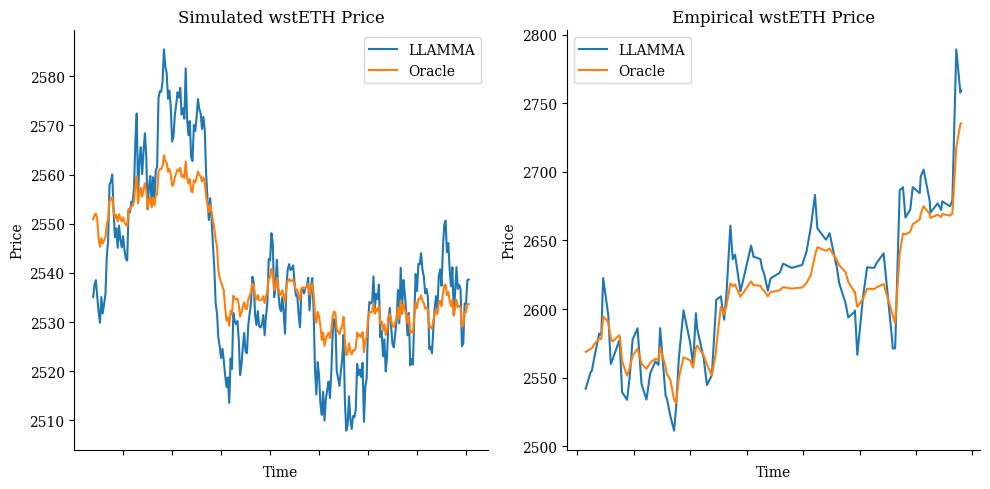

In [137]:
from src.configs.tokens import *

f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
s = 10
e = -1
run = results[4].data[1]
run.df["Llamma Wsteth Price"].iloc[s:e].plot(label="LLAMMA", ax=ax)
run.df["Llamma Wsteth Oracle Price"].iloc[s:e].plot(label="Oracle", ax=ax)

ax.legend()
ax.set_ylabel("Price")
ax.set_xlabel("Time")
ax.set_title("Simulated wstETH Price")
ax.set_xticklabels([])

ax = axs[1]
df["ammPrice"].plot(label="LLAMMA", ax=ax)
df["oraclePrice"].plot(label="Oracle", ax=ax)
ax.set_ylabel("Price")
ax.set_xlabel("Time")
ax.set_title("Empirical wstETH Price")
ax.set_xticklabels([])
ax.legend()

f.tight_layout()
f.savefig("../figs/misc/llamma_prices.png")
plt.show()

In [150]:
run.df[["Llamma Wsteth Oracle Price", "Llamma Wsteth Price"]].to_csv("foo.csv")

In [160]:
results[4].metadata

{'scenario': 'baseline',
 'num_iter': 1000,
 'markets': ['wbtc', 'weth', 'sfrxeth', 'wsteth'],
 'num_steps': 288,
 'freq': '5min',
 'template': <src.sim.scenario.Scenario at 0x36d7f3990>,
 'params': {}}

# crvUSD Interest Rate Revenue

In [199]:
async def get_fees():
    end_ts = int(datetime.now(timezone.utc).timestamp())
    # pylint: disable=consider-using-f-string
    template_query = """
        query CollectedFees{
            collectedFees(
                orderBy: blockTimestamp,
                orderDirection: desc,
                first: 1000,
                where: {
                    blockTimestamp_lte: $end_ts
                }
            ) {
                blockTimestamp
                market {
                    collateralName
                }
                borrowingFees
            }
        }
    """

    q = Template(template_query).substitute(end_ts=end_ts)
    r = await convex_crvusd(q)
    df = pd.DataFrame(r["collectedFees"])
    df["market"] = df["market"].apply(lambda x: x["collateralName"])
    df.index = pd.to_datetime(df["blockTimestamp"].astype(float), unit="s")
    df.drop(["blockTimestamp"], axis=1, inplace=True)
    df["borrowingFees"] = df["borrowingFees"].astype(float)
    df.sort_index(inplace=True)
    return df

get_fees = sync(get_fees)

df = get_fees()
assert df.shape[0] < 1000, "Did not fetch enough"
df.head()

,market,borrowingFees
blockTimestamp,,
2023-05-23 08:59:35,sfrxETH,2569.687316
2023-05-28 20:48:47,sfrxETH,1727.131361
2023-06-13 08:34:11,sfrxETH,12666.818739
2023-06-13 08:34:23,wstETH,5907.825325
2023-06-18 20:11:11,sfrxETH,6037.868584


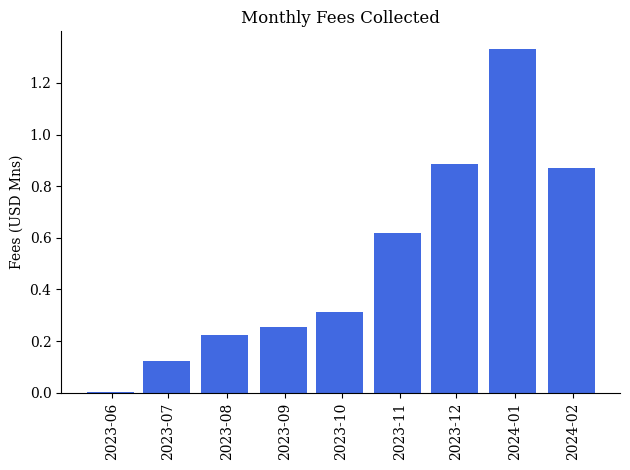

In [200]:
monthly = df["borrowingFees"].groupby(pd.Grouper(freq="M")).sum()

f, ax = plt.subplots()

ax.bar(monthly.index, monthly / 1e6, width=25, color="royalblue")
ax.tick_params("x", rotation=90)
ax.set_ylabel("Fees (USD Mns)")
ax.set_title("Monthly Fees Collected")
f.tight_layout()
f.savefig("../figs/misc/monthly_fees.png", dpi=300)
plt.show()

In [201]:
df["borrowingFees"].sum() / 1e6

4.626576653153386